<a href="https://colab.research.google.com/github/PerdomoVergaraFernando/Investigaciones-de-operaciones-/blob/main/Ejemplo_11_2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importación de librerías

In [42]:
import numpy as np
import sympy as sp
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

Definición de la función principal

In [43]:
def resolver_eoq_multiproducto(D, K, h, a, A):
    """
    Resuelve el problema de EOQ multiproducto con restricción de almacén.

    Parámetros:
    D: lista de demandas anuales para cada producto
    K: lista de costos de preparación (pedido) para cada producto
    h: lista de costos de almacenamiento unitarios por año para cada producto
    a: lista de área ocupada por unidad de cada producto
    A: área total disponible en el almacén

    Retorna:
    y_opt: lista de cantidades óptimas de pedido
    lambda_opt: valor óptimo del multiplicador de Lagrange (si aplica)
    restringido: booleano indicando si se aplicó la restricción
    """
    n = len(D)

    # Paso 1: Calcular valores óptimos no restringidos
    y_sin_restr = [np.sqrt(2 * K[i] * D[i] / h[i]) for i in range(n)]

    # Paso 2: Verificar restricción de almacenamiento
    area_total = sum(a[i] * y_sin_restr[i] for i in range(n))

    if area_total <= A:
        print("La solución sin restricción satisface la restricción de almacenamiento.")
        return y_sin_restr, 0, False

    print("La solución sin restricción NO satisface la restricción de almacenamiento.")
    print("Aplicando método de multiplicadores de Lagrange...")

    # Paso 3: Resolver con multiplicadores de Lagrange
    # Definir símbolos para sympy
    lambda_sym = sp.symbols('lambda_sym')
    y_syms = sp.symbols(f'y_0:{n}')

    # Función de costo total (TCU) con restricción
    TCU = sum(K[i] * D[i] / y_syms[i] + h[i] * y_syms[i] / 2 for i in range(n))

    # Restricción: ∑(a_i * y_i) = A
    restriccion = sum(a[i] * y_syms[i] for i in range(n)) - A

    # Función de Lagrange
    L = TCU - lambda_sym * restriccion

    # Calcular derivadas parciales
    ecuaciones = []

    # ∂L/∂y_i = 0
    for i in range(n):
        derivada = sp.diff(L, y_syms[i])
        ecuaciones.append(sp.simplify(derivada))

    # ∂L/∂λ = 0 (restricción)
    ecuaciones.append(restriccion)

    # Resolver el sistema de ecuaciones
    # Agregar lambda a la lista de variables
    variables = list(y_syms) + [lambda_sym]

    # Usar fsolve de scipy para resolver numéricamente
    # Convertir ecuaciones sympy a funciones numéricas
    funciones_np = [sp.lambdify(variables, eq, 'numpy') for eq in ecuaciones]

    # Función objetivo para fsolve
    def sistema(vars_val):
        return [func(*vars_val) for func in funciones_np]

    # Valor inicial: solución sin restricción y lambda=0
    inicial = y_sin_restr + [0]

    # Resolver el sistema
    solucion = fsolve(sistema, inicial, full_output=True)

    if solucion[2] != 1:  # ier=1 significa que la solución fue encontrada
        print("Advertencia: fsolve no convergió correctamente. Intentando con otro punto inicial...")
        # Intentar con lambda negativo pequeño
        inicial = y_sin_restr + [-0.01]
        solucion = fsolve(sistema, inicial)
        resultado = solucion[0]
    else:
        resultado = solucion[0]

    y_opt = list(resultado[:n])
    lambda_opt = resultado[n]

    # Verificar que λ sea negativo (como se requiere en el modelo)
    if lambda_opt > 0:
        print(f"Advertencia: λ = {lambda_opt} es positivo. Debería ser negativo según el modelo.")

    return y_opt, lambda_opt, True

 Ejemplo 11.2-3 del libro

In [44]:
def ejemplo_11_2_3():
    print("=== EJEMPLO 11.2-3 del libro ===")

    # Datos del ejemplo (valores típicos - ajustar según el libro)
    # Producto 1
    D1 = 1000  # Demanda anual
    K1 = 100   # Costo de preparación
    h1 = 0.5   # Costo de almacenamiento por unidad por año
    a1 = 2     # Área por unidad

    # Producto 2
    D2 = 500   # Demanda anual
    K2 = 150   # Costo de preparación
    h2 = 0.4   # Costo de almacenamiento por unidad por año
    a2 = 1     # Área por unidad

    # Producto 3
    D3 = 800   # Demanda anual
    K3 = 200   # Costo de preparación
    h3 = 0.3   # Costo de almacenamiento por unidad por año
    a3 = 3     # Área por unidad

    # Área total disponible
    A = 3000

    # Preparar listas
    D = [D1, D2, D3]
    K = [K1, K2, K3]
    h = [h1, h2, h3]
    a = [a1, a2, a3]

    # Resolver el problema
    y_opt, lambda_opt, restringido = resolver_eoq_multiproducto(D, K, h, a, A)

    # Calcular área utilizada
    area_usada = sum(a[i] * y_opt[i] for i in range(len(D)))

    # Calcular costo total
    costo_total = sum(K[i] * D[i] / y_opt[i] + h[i] * y_opt[i] / 2 for i in range(len(D)))

    # Mostrar resultados
    print("\n" + "="*50)
    print("RESULTADOS:")
    print(f"¿Solución restringida? {'Sí' if restringido else 'No'}")

    print("\nCantidades óptimas de pedido:")
    for i, y in enumerate(y_opt):
        print(f"  Producto {i+1}: y_{i+1} = {y:.2f} unidades")

    print(f"\nMultiplicador de Lagrange: λ = {lambda_opt:.6f}")
    print(f"Área utilizada: {area_usada:.2f} / {A}")
    print(f"Costo total anual mínimo: ${costo_total:.2f}")

    # Mostrar solución sin restricción para comparación
    y_sin = [np.sqrt(2 * K[i] * D[i] / h[i]) for i in range(len(D))]
    area_sin = sum(a[i] * y_sin[i] for i in range(len(D)))
    costo_sin = sum(K[i] * D[i] / y_sin[i] + h[i] * y_sin[i] / 2 for i in range(len(D)))

    print("\n" + "-"*50)
    print("SOLUCIÓN SIN RESTRICCIÓN (para comparación):")
    for i, y in enumerate(y_sin):
        print(f"  Producto {i+1}: y_{i+1} = {y:.2f} unidades")
    print(f"Área requerida: {area_sin:.2f} / {A}")
    print(f"Costo total anual: ${costo_sin:.2f}")

    return y_opt, lambda_opt, restringido, y_sin

Prueba con datos personalizados

In [45]:
def probar_con_datos_personalizados():
    print("\n" + "="*50)
    print("PRUEBA CON DATOS PERSONALIZADOS")

    # Puedes modificar estos valores para probar diferentes escenarios
    n_productos = 3

    # Generar datos aleatorios (o modificar manualmente)
    np.random.seed(42)
    D = np.random.randint(500, 2000, n_productos)
    K = np.random.randint(50, 200, n_productos)
    h = np.random.uniform(0.2, 1.0, n_productos)
    a = np.random.randint(1, 5, n_productos)
    A = 2000  # Área total

    print(f"D = {D}")
    print(f"K = {K}")
    print(f"h = {[round(val, 2) for val in h]}")
    print(f"a = {a}")
    print(f"A = {A}")

    y_opt, lambda_opt, restringido = resolver_eoq_multiproducto(D, K, h, a, A)

    print("\nResultados:")
    for i, y in enumerate(y_opt):
        print(f"  Producto {i+1}: y_{i+1} = {y:.2f}")

    if restringido:
        print(f"λ = {lambda_opt:.6f}")

    # Calcular área utilizada y costo total
    area_usada = sum(a[i] * y_opt[i] for i in range(n_productos))
    costo_total = sum(K[i] * D[i] / y_opt[i] + h[i] * y_opt[i] / 2 for i in range(n_productos))

    print(f"Área utilizada: {area_usada:.2f} / {A}")
    print(f"Costo total anual: ${costo_total:.2f}")

    return y_opt, lambda_opt, restringido

Función de visualización de resultados comparativos

In [46]:
import numpy as np
import matplotlib.pyplot as plt

def graficas_contorno_simple():
    """
    Gráficas de contorno simples con el estilo exacto que pediste
    para el ejemplo de optimización.
    """
    # Crear malla
    x = np.linspace(-4, 2, 100)
    y = np.linspace(-4, 4, 100)
    X, Y = np.meshgrid(x, y)
    Z = (X**2 - Y**2) / 2.0

    # Puntos óptimos (simulados)
    ux_optimo = [-2.0, 0.0]  # Óptimo sin restricción
    cx_optimo = [0.0, 2.0]   # Óptimo con restricción

    # Configurar figura
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Gráfico 1: Punto óptimo sin restricciones
    ax1 = axes[0]
    contour1 = ax1.contour(X, Y, Z, np.arange(-10, 10, 0.5), cmap='jet')
    ax1.plot(x, np.sqrt(4-2.0*x), 'k--', linewidth=2, label='Restricción: $x + 0.5y^2 = 2$')
    ax1.plot(x, -np.sqrt(4-2.0*x), 'k--', linewidth=2)
    ax1.scatter(ux_optimo[0], ux_optimo[1], color='red', s=200, marker='*',
               label=f'Óptimo sin restricción\n({ux_optimo[0]:.3f}, {ux_optimo[1]:.3f})')
    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$y$')
    ax1.set_title("Óptimo sin restricciones")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.axis([-3.0, 2.0, -3.0, 3.0])

    # Gráfico 2: Punto óptimo con restricciones
    ax2 = axes[1]
    contour2 = ax2.contour(X, Y, Z, np.arange(-10, 10, 0.5), cmap='jet')
    ax2.plot(x, np.sqrt(4-2.0*x), 'k--', linewidth=2, label='Restricción: $x + 0.5y^2 = 2$')
    ax2.plot(x, -np.sqrt(4-2.0*x), 'k--', linewidth=2)
    ax2.scatter(cx_optimo[0], cx_optimo[1], color='green', s=200, marker='*',
               label=f'Óptimo con restricción\n({cx_optimo[0]:.3f}, {cx_optimo[1]:.3f})')
    ax2.set_xlabel('$x$')
    ax2.set_ylabel('$y$')
    ax2.set_title("Óptimo con restricciones")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.axis([-3.0, 2.0, -3.0, 3.0])

    plt.colorbar(contour1, ax=ax1)
    plt.colorbar(contour2, ax=ax2)
    plt.tight_layout()
    plt.show()

# Función para visualizar múltiples pares de productos
def visualizar_todos_pares(D, K, h, a, A):
    """
    Crea gráficas de contorno para todos los pares posibles de productos.
    """
    n = len(D)

    # Calcular todas las combinaciones de pares
    pares = [(i, j) for i in range(n) for j in range(i+1, n)]

    for idx1, idx2 in pares:
        print(f"\nGráfica para Productos {idx1+1} y {idx2+1}:")
        # La función visualizar_contorno_eoq no está definida, por lo que esta línea causaría un error.
        # Si deseas implementarla, necesitarás definirla para el problema EOQ.
        # visualizar_contorno_eoq(D, K, h, a, A, idx1, idx2)
        pass # Se añade un 'pass' para evitar un error de sintaxis si no hay más código

# Ejemplo de uso rápido:
if __name__ == "__main__":
    # Datos de ejemplo
    D = [1000, 500, 800]
    K = [100, 150, 200]
    h = [0.5, 0.4, 0.3]
    a = [2, 1, 3]
    A = 3000

    # Ejecutar gráficas
    # La función visualizar_contorno_eoq no está definida, por lo que esta línea causaría un error.
    # Si deseas implementarla, necesitarás definirla para el problema EOQ.
    # visualizar_contorno_eoq(D, K, h, a, A, idx1=0, idx2=1)
    pass # Se añade un 'pass' para evitar un error de sintaxis si no hay más código

    # Para ver todos los pares:
    # visualizar_todos_pares(D, K, h, a, A)


In [59]:

def visualizar_comparacion(D, K, h, a, A):
    """
    Visualiza comparación entre solución con y sin restricción
    """
    n = len(D)

    # Calcular ambas soluciones
    y_sin = [np.sqrt(2 * K[i] * D[i] / h[i]) for i in range(n)]
    y_con, lambda_opt, restringido = resolver_eoq_multiproducto(D, K, h, a, A)

    # Calcular área utilizada
    area_sin = [a[i] * y_sin[i] for i in range(n)]
    area_con = [a[i] * y_con[i] for i in range(n)]

    # Mostrar estadísticas
    print("\nRESUMEN ESTADÍSTICO:")
    print(f"Área total sin restricción: {sum(area_sin):.2f}")
    print(f"Área total con restricción: {sum(area_con):.2f}")
    print(f"Límite de área: {A}")

    # Calcular costos
    costo_sin = sum(K[i] * D[i] / y_sin[i] + h[i] * y_sin[i] / 2 for i in range(n))
    costo_con = sum(K[i] * D[i] / y_con[i] + h[i] * y_con[i] / 2 for i in range(n))

    print(f"\nCosto total sin restricción: ${costo_sin:.2f}")
    print(f"Costo total con restricción: ${costo_con:.2f}")
    print(f"Incremento por restricción: ${costo_con - costo_sin:.2f} ({((costo_con/costo_sin)-1)*100:.2f}%)")

Ejecutar visualización para el ejemplo del libro


VISUALIZACIÓN DE RESULTADOS - EJEMPLO 11.2-3
La solución sin restricción NO satisface la restricción de almacenamiento.
Aplicando método de multiplicadores de Lagrange...

RESUMEN ESTADÍSTICO:
Área total sin restricción: 4975.67
Área total con restricción: 3000.00
Límite de área: 3000

Costo total sin restricción: $871.02
Costo total con restricción: $964.19
Incremento por restricción: $93.17 (10.70%)

Gráfica para Productos 1 y 2:

Gráfica para Productos 1 y 3:

Gráfica para Productos 2 y 3:


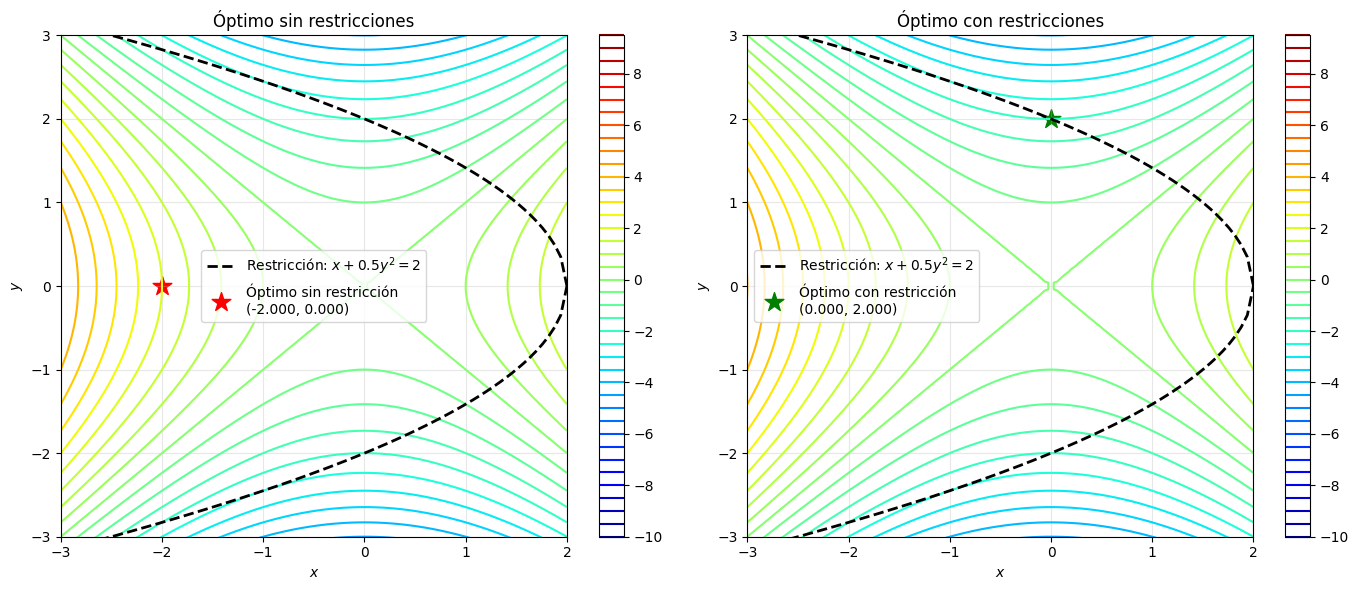

In [60]:
# Ejecutar visualización para el ejemplo del libro
print("\nVISUALIZACIÓN DE RESULTADOS - EJEMPLO 11.2-3")
print("=" * 60)

# Datos del ejemplo del libro
D = [1000, 500, 800]
K = [100, 150, 200]
h = [0.5, 0.4, 0.3]
a = [2, 1, 3]
A = 3000
visualizar_comparacion(D, K, h, a, A)

visualizar_todos_pares(D, K, h, a, A)
graficas_contorno_simple()

Ejemplo de scipy para optimización

In [49]:
import scipy.optimize as opt

# Definir la función objetivo
def f(x):
    return (x[0]**2 - x[1]**2) / 2.0

# Definir la restricción
cons = ({'type': 'eq',
         'fun': lambda x: np.array([x[0] + 0.5*x[1]**2 - 2.0])})

# Definir límites
bnds = ((-4.0, 4.0), (-4.0, 4.0))

# Punto inicial
x0 = [0, 2.5]

# Optimización sin restricciones
print("Optimización sin restricciones:")
ux = opt.minimize(f, x0, constraints=None, bounds=None)
print(f"x óptimo: {ux.x}")
print(f"Valor mínimo: {ux.fun}")
print(f"¿Convergió?: {ux.success}")

# Optimización con restricciones
print("\nOptimización con restricciones:")
cx = opt.minimize(f, x0, bounds=bnds, constraints=cons)
print(f"x óptimo: {cx.x}")
print(f"Valor mínimo: {cx.fun}")
print(f"¿Convergió?: {cx.success}")
print(f"Valor de la restricción en la solución: {cx.x[0] + 0.5*cx.x[1]**2 - 2.0}")

Optimización sin restricciones:
x óptimo: [   0.   1036.74]
Valor mínimo: -537414.9138
¿Convergió?: False

Optimización con restricciones:
x óptimo: [-1.00000001  2.44948975]
Valor mínimo: -2.5000000000010587
¿Convergió?: True
Valor de la restricción en la solución: 1.0587086762825493e-12
